# Ice Floe Tracker data quality and consistency
The initial skill score using the test set from the logistic regression training is the fairest and most straightforward check. Here, we aim to summarize the data, and we want to examine the relationships between variables in the training dataset compared to the final cleaned dataset.

## Data summary figures
1. Histogram comparison: data frequency by bin pre and post QC
2. Time series: number of observations in each category by year and by month.
3. Length of identified trajectories
4. Number of velocity snapshots per month by year
5. Floe size distribution per month and by year

In [47]:
import pandas as pd
import numpy as np
import proplot as pplt
import cartopy.crs as ccrs
import warnings
warnings.simplefilter('ignore')
pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'

In [48]:
#### Load classified data
ift_dfs = {}
dataloc = '../data/temp/floe_properties_classified/'
for year in range(2003, 2021):
    ift_dfs[year] = pd.read_csv(dataloc + 'ift_raw_floe_properties_{y}.csv'.format(y=year))
    ift_dfs[year]['datetime'] = pd.to_datetime(ift_dfs[year].datetime.values)

# Spatial distribution of data
Here we bin the data by 25 km-on-a-side grid cells and look at the initial distribution, the distribution of the filtered tracked floes that were used in the logistic regression (LR) training data, the false positives used for the training data (low circularity or solidity, objects with 0% SIC, objects over land, and objects with anomalous size relative to sea ice concentration). Then, we look at the results of the logistic regression. The "Final TP" category is the initial true positives and LR true positives, minus the values labeled initially as false positives.

In [49]:
year = 2004
xmin = 0.2e6
xmax = 1.2e6
ymin = -2.5e6
ymax = -0.25e6
dx = 25e3
xbins = np.arange(xmin, xmax, dx)
ybins = np.arange(ymin, ymax, dx)
xc = 0.5*(xbins[1:] + xbins[:-1])
yc = 0.5*(ybins[1:] + ybins[:-1])

all_data = pd.concat([ift_dfs[year] for year in ift_dfs])

In [74]:
ift_dfs[year].orientation.max()

1.5707274937449784

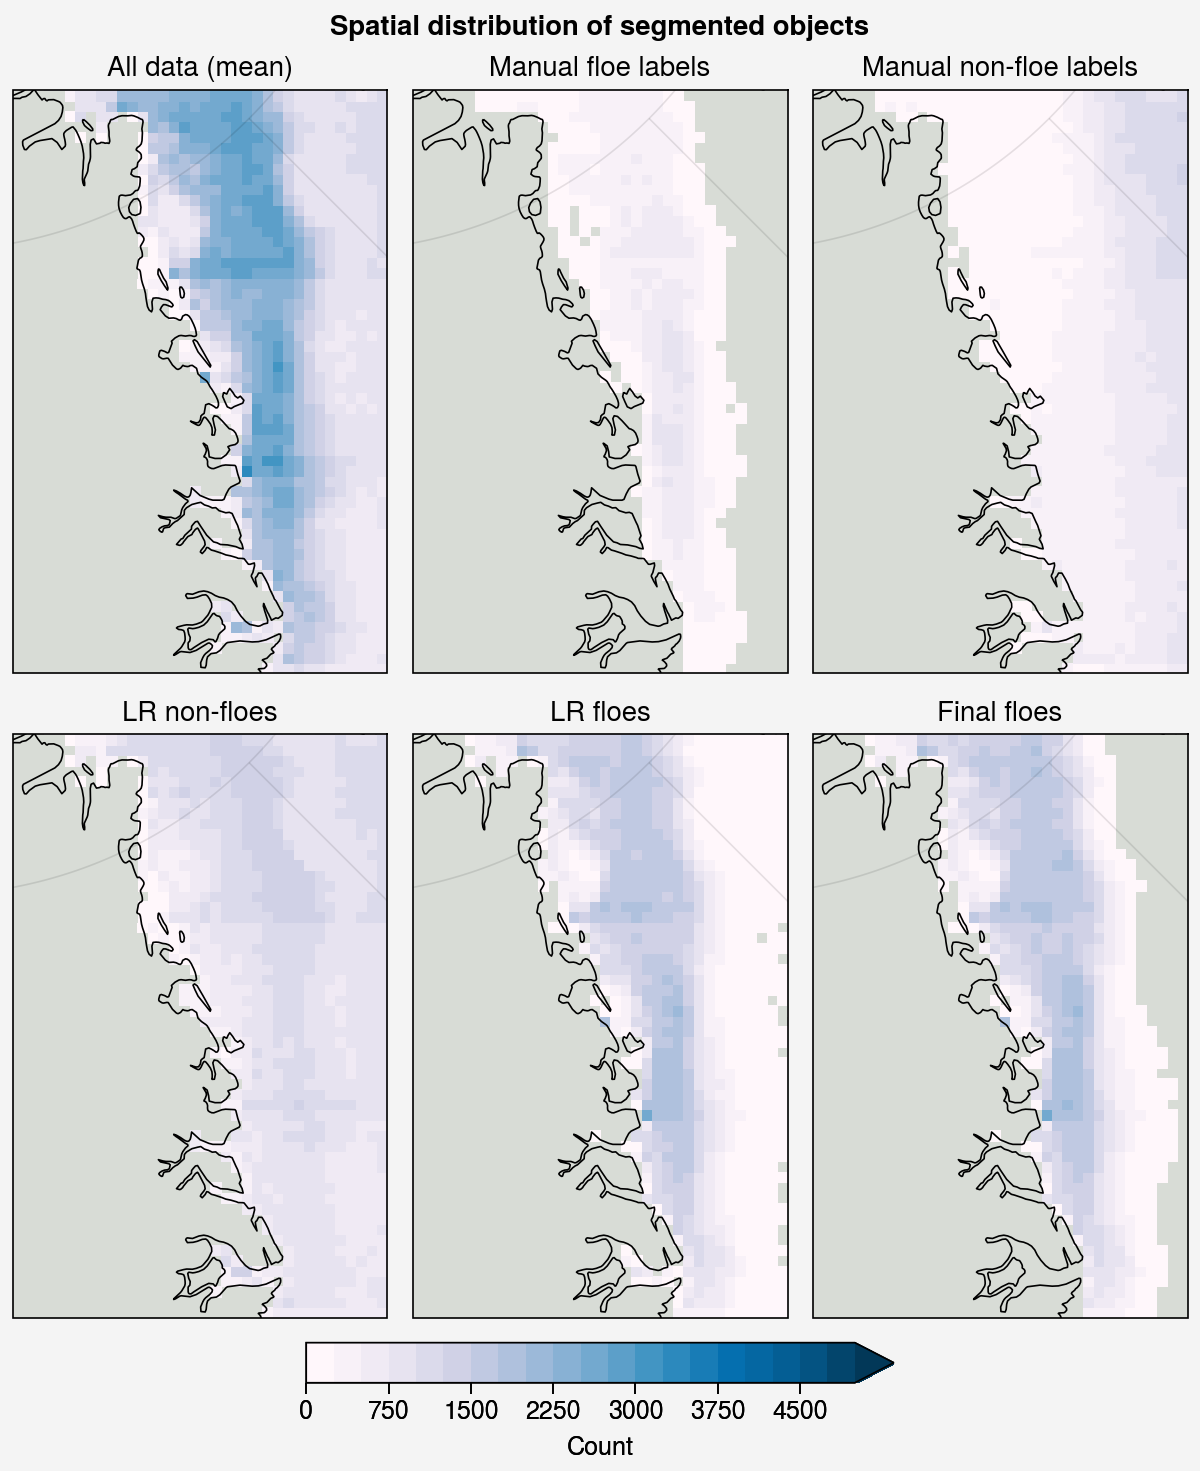

In [51]:
idx_all = all_data.index
true_positives_init = all_data.init_classification == 'TP'
false_positives_init = all_data.init_classification == 'FP'
lr_false_positives = ~all_data.lr_classification.fillna(False)
lr_true_positives = all_data.lr_classification.fillna(False)
final_tp = all_data.final_classification
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=3, nrows=2)
axs.format(land=False, coast=True, landzorder=0, facecolor='light gray')
for ax, idx, title in zip(axs, [idx_all, true_positives_init, false_positives_init, lr_false_positives, lr_true_positives, final_tp],
                             ['All data (mean)', 'Manual floe labels', 'Manual non-floe labels', 'LR non-floes', 'LR floes', 'Final floes']):
    ax.set_extent([0.2e6, 1.1e6, -2.1e6, -0.7e6], crs=crs)
    df = all_data.loc[idx,:]
        
    data, _, _ = np.histogram2d(df.x_stere, df.y_stere, bins=[xbins, ybins])
    if title == 'All data (mean)':
        data /= 18
    data = pd.DataFrame(data, index=xc, columns=yc)
    c = ax.pcolormesh(xc, yc, data.where(data >= 30).T, transform=crs, cmap='PuBu', vmin=0, vmax=5000, N=20, extend='max')
    ax.format(title=title)
axs.format(suptitle='Spatial distribution of segmented objects')
fig.colorbar(c, loc='b', label='Count', shrink=0.5)
fig.save('../figures/spatial_histograms/ift_spatial_histogram_all_years.png', dpi=300)

In [52]:
#### QC Figures: Year-by-year spatial distributions of data ####
for year in ift_dfs:
    idx_all = ift_dfs[year].index
    true_positives_init = ift_dfs[year].init_classification == 'TP'
    false_positives_init = ift_dfs[year].init_classification == 'FP'
    lr_false_positives = ~ift_dfs[year].lr_classification.fillna(False)
    lr_true_positives = ift_dfs[year].lr_classification.fillna(False)
    final_tp = ift_dfs[year].final_classification
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
    fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=3, nrows=2)
    axs.format(land=False, coast=True, landzorder=0, facecolor='gray')
    for ax, idx, title in zip(axs, [idx_all, true_positives_init, false_positives_init, lr_false_positives, lr_true_positives, final_tp],
                                 ['All data', 'Init TP', 'Init FP', 'LR FP', 'LR TP', 'Final TP']):
        ax.set_extent([0.2e6, 1.1e6, -2.1e6, -0.7e6], crs=crs)
        df = ift_dfs[year].loc[idx,:]
        data, _, _ = np.histogram2d(df.x_stere, df.y_stere, bins=[xbins, ybins])
        data = pd.DataFrame(data, index=xc, columns=yc)
        c = ax.pcolormesh(xc, yc, data.where(data > 0).T, transform=crs, cmap='PuBu', vmin=0, vmax=300, extend='max')
        ax.format(title=title)
    axs.format(suptitle='Spatial distribution of segmented objects ({y})'.format(y=year))
    fig.colorbar(c, loc='b', label='Count', shrink=0.5)
    fig.save('../figures/spatial_histograms/ift_spatial_histograms_{y}.png'.format(y=year), dpi=300)
    pplt.close(fig)

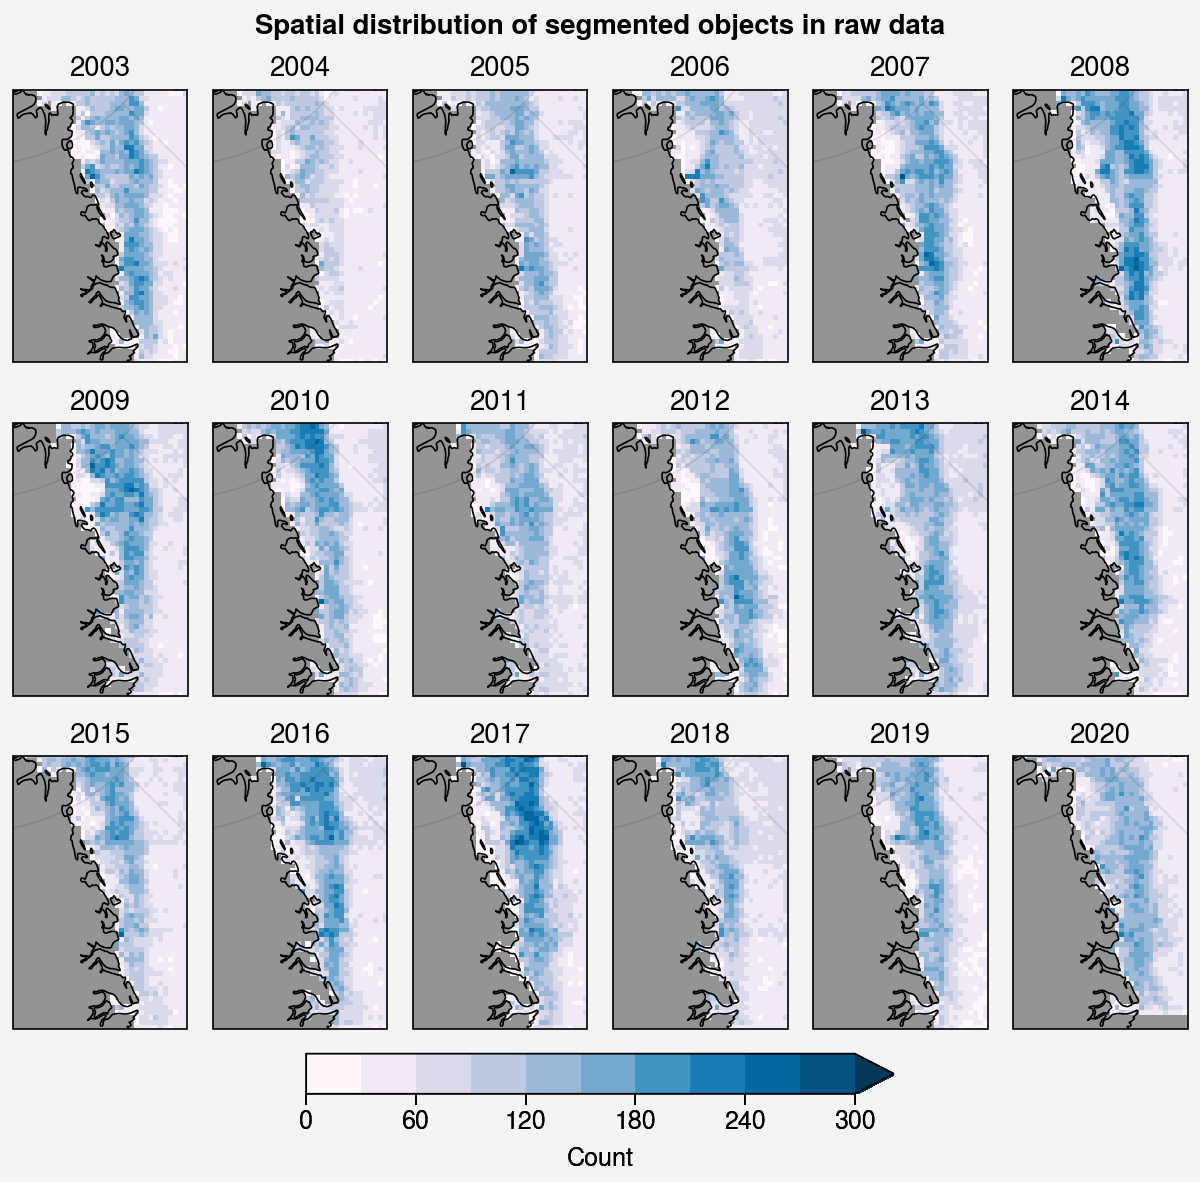

In [53]:
#### QC Figures: Year-by-year spatial distributions of data ####
fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=6, nrows=3)
axs.format(land=False, coast=True, landzorder=0, facecolor='gray')
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
for ax, year in zip(axs, ift_dfs):
    ax.set_extent([0.2e6, 1.1e6, -2.1e6, -0.7e6], crs=crs)
    df = ift_dfs[year]
    data, _, _ = np.histogram2d(df.x_stere, df.y_stere, bins=[xbins, ybins])
    data = pd.DataFrame(data, index=xc, columns=yc)
    c = ax.pcolormesh(xc, yc, data.where(data > 0).T, transform=crs, cmap='PuBu', vmin=0, vmax=300, extend='max')
    ax.format(title=year)
axs.format(suptitle='Spatial distribution of segmented objects in raw data'.format(y=year))
fig.colorbar(c, loc='b', label='Count', shrink=0.5)
fig.save('../figures/spatial_histograms/ift_spatial_histograms_all_years_init.png'.format(y=year), dpi=300)

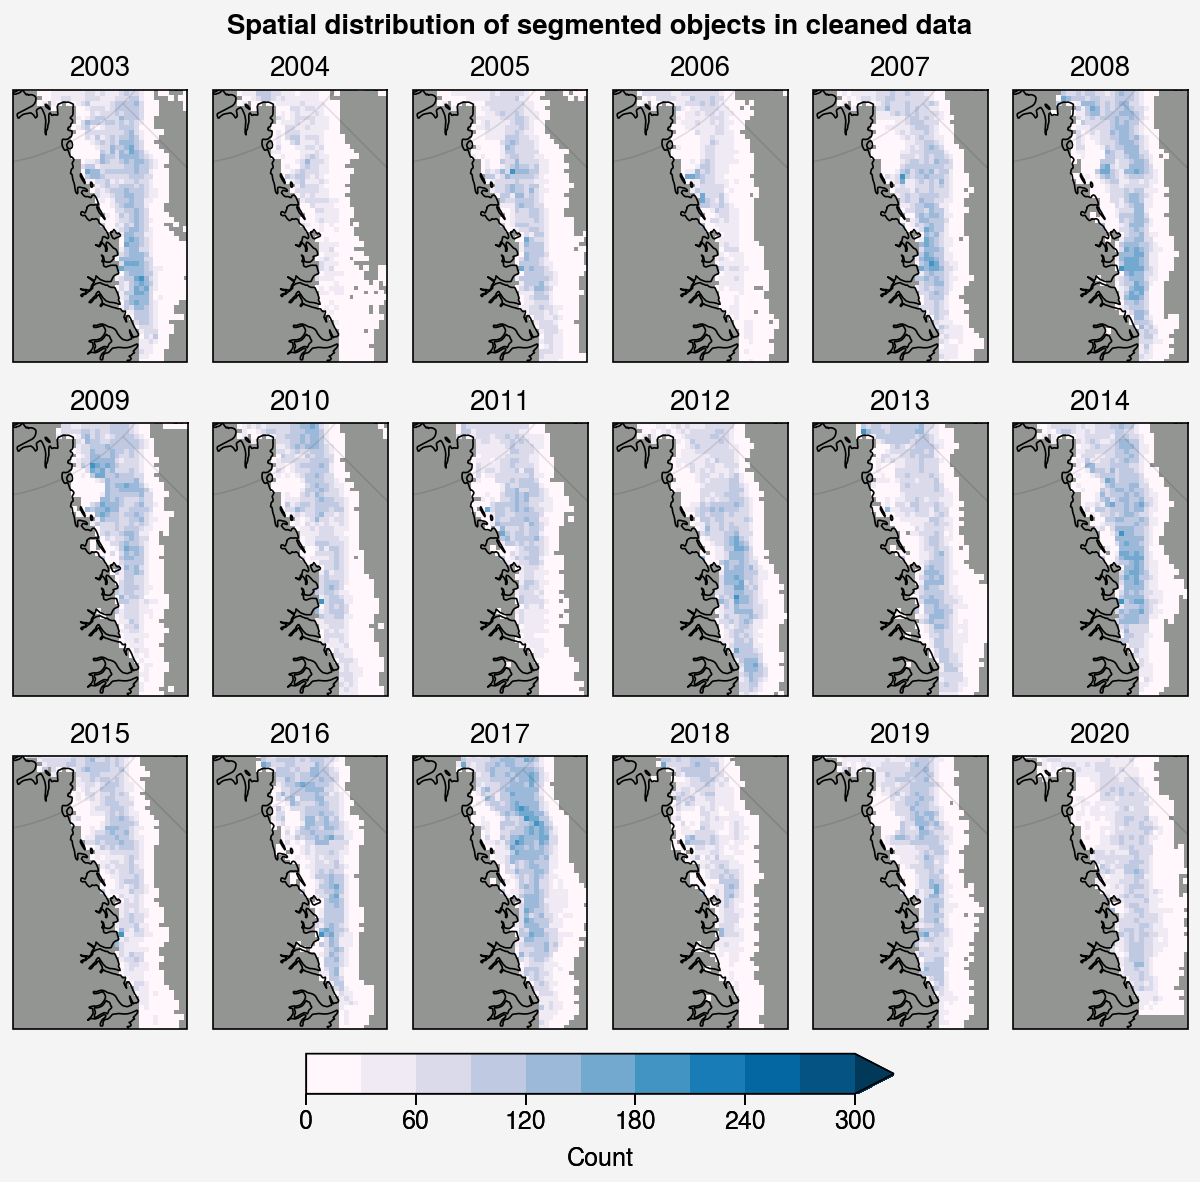

In [54]:
#### QC Figures: Year-by-year spatial distributions of data after cleaning ####
fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=6, nrows=3)
axs.format(land=False, coast=True, landzorder=0, facecolor='gray')
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
for ax, year in zip(axs, ift_dfs):
    ax.set_extent([0.2e6, 1.1e6, -2.1e6, -0.7e6], crs=crs)
    df = ift_dfs[year].loc[ift_dfs[year].final_classification & (ift_dfs[year].nsidc_sic != 2.53), :]
    data, _, _ = np.histogram2d(df.x_stere, df.y_stere, bins=[xbins, ybins])
    data = pd.DataFrame(data, index=xc, columns=yc)
    c = ax.pcolormesh(xc, yc, data.where(data > 0).T, transform=crs, cmap='PuBu', vmin=0, vmax=300, extend='max')
    ax.format(title=year)
axs.format(suptitle='Spatial distribution of segmented objects in cleaned data'.format(y=year))
fig.colorbar(c, loc='b', label='Count', shrink=0.5)
fig.save('../figures/spatial_histograms/ift_spatial_histograms_all_years_final.png'.format(y=year), dpi=300)

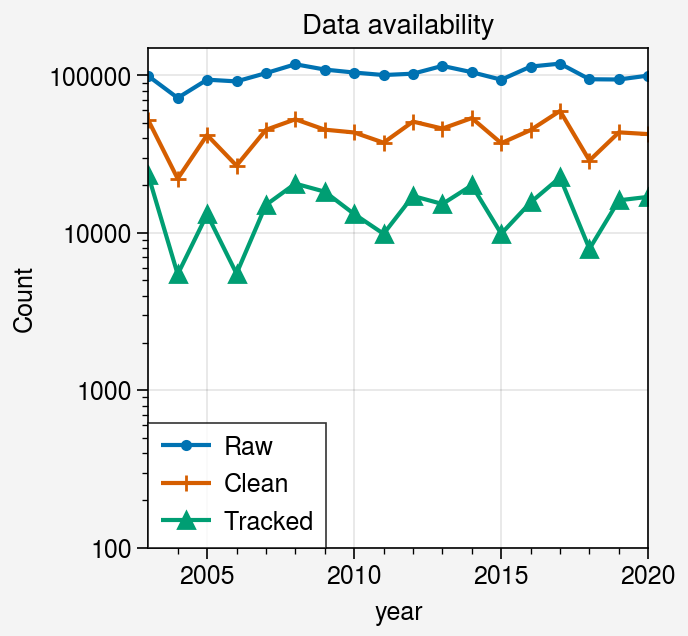

In [83]:

data = []
for year in range(2003, 2021):
    n = len(ift_dfs[year])
    amax = ift_dfs[year].area.max()
    amin = ift_dfs[year].area.min()
    n_passing = len(ift_dfs[year][ift_dfs[year].final_classification])
    n_tracked = len(ift_dfs[year][ift_dfs[year].floe_id != 'unmatched']) # This counts multiples
    data.append([year, amax, amin, n, n_passing, n_tracked])
data_table = pd.DataFrame(data, columns=['year', 'max_pixels', 'min_pixels', 'n_init', 'n_passing', 'n_tracked'])
data_table.set_index('year', inplace=True)


fig, ax = pplt.subplots()
ax.plot(data_table.index.values, data_table['n_init'].values, label='Raw', marker='.')
ax.plot(data_table.index.values, data_table['n_passing'].values, label='Clean', marker='+')
ax.plot(data_table.index.values, data_table['n_tracked'].values, label='Tracked', marker='^')
ax.legend(loc='ll', ncols=1)
ax.format(ylabel='Count', xlabel='year', ylim=(100, 150000), yscale='log', title='Data availability')

In [ ]:
c = pplt.Cycle('spectral', 18)
colors = {year: c['color'] for c, year in zip(c, np.arange(2003, 2021))}
fig, ax = pplt.subplots()
h = []
for year, group in trajectories.groupby(trajectories.datetime.dt.year):
    n = group.groupby('floe_id').apply(lambda x: len(x), include_groups=False)
    x, bins = np.histogram(n, bins=np.arange(0.5, 20))
    xc = 0.5*(bins[1:] + bins[:-1])
    h.append(ax.plot(xc[1:], x[1:], marker='.', color=colors[year]))
ax.legend(h, [x for x in colors], loc='ur', ncols=2, order='F')
ax.format(ylabel='Count', xlabel='Length (days)', title='Length of trajectories')
fig.save('../figures/trajectory_length.png', dpi=300)

In [85]:
ift_dfs[2014].loc[ift_dfs[2014].datetime.dt.month == 5]

Unnamed: 0            datetime satellite    floe_id  label  longitude  \
26855       26855 2014-05-01 12:14:19      aqua  unmatched    252   -16.8158   
26856       26856 2014-05-01 12:14:19      aqua  unmatched    254   -18.3085   
26857       26857 2014-05-01 12:14:19      aqua  unmatched    251    -0.1753   
26858       26858 2014-05-01 12:14:19      aqua  unmatched    213   -21.5662   
26859       26859 2014-05-01 12:14:19      aqua  unmatched    250    -8.1063   
...           ...                 ...       ...        ...    ...        ...   
59747       59747 2014-05-31 13:43:59     terra  unmatched     21   -11.4794   
59748       59748 2014-05-31 13:43:59     terra  unmatched     23    -9.9189   
59749       59749 2014-05-31 13:43:59     terra  unmatched     27   -10.0140   
59750       59750 2014-05-31 13:43:59     terra  unmatched     30    -8.6827   
59751       59751 2014-05-31 13:43:59     terra  unmatched     31   -10.7744   

       latitude   x_stere    y_stere    col_pixel  ...  tc_channel0  \
26855   72.7787  887532.0 -1656338.2  2499.303191  ...        227.9   
26856   71.8697  889344.7 -1768916.3  2506.383812  ...        233.7   
26857   78.3977  888922.3  -894377.3  2504.734114  ...        112.8   
26858   70.0048  869902.8 -2006982.9  2430.439060  ...        231.3   
26859   76.3444  892114.2 -1188455.5  2517.202418  ...        212.7   
...         ...       ...        ...          ...  ...          ...   
59747   82.5811  444413.0  -670910.4   768.369388  ...        223.7   
59748   82.7916  449358.0  -639820.6   787.685876  ...        223.7   
59749   82.6265  458592.9  -655280.1   823.759615  ...        223.0   
59750   82.6826  470076.7  -639526.7   868.618421  ...        223.7   
59751   82.3698  465560.2  -684393.6   850.975871  ...        226.8   

       tc_channel1  tc_channel2  fc_channel0  fc_channel1  fc_channel2  \
26855        226.0        224.5          3.3        234.9        238.6   
26856        231.6        229.6          1.8        240.1        242.6   
26857        115.9        126.0         75.2        106.5        108.0   
26858        233.0        232.8          4.5        233.7        240.8   
26859        213.5        217.4        137.1        224.9        228.6   
...            ...          ...          ...          ...          ...   
59747        223.4        227.7        136.0        232.2        237.0   
59748        223.2        228.1        133.7        232.1        236.7   
59749        222.4        227.4        141.1        231.4        236.7   
59750        223.5        228.0        138.3        231.9        236.6   
59751        225.8        226.7         47.1        232.8        239.4   

       init_classification  lr_probability  lr_classification  \
26855                   UK           0.999               True   
26856                   UK           0.999               True   
26857                   UK           0.000              False   
26858                   UK           0.995               True   
26859                   UK           0.355              False   
...                    ...             ...                ...   
59747                   UK           0.591               True   
59748                   UK           0.179              False   
59749                   UK           0.843               True   
59750                   UK           0.094              False   
59751                   UK           0.806               True   

       final_classification  
26855                  True  
26856                  True  
26857                 False  
26858                  True  
26859                 False  
...                     ...  
59747                  True  
59748                 False  
59749                  True  
59750                 False  
59751                  True  

[32897 rows x 39 columns]

The quality control process does remove many of the spurious floes, especially around the margins. There are a few bins that frequently have very high counts, which I interpret as likely landfast ice or coast mask artifacts that recur with high frequency. To check these, we can use the numpy digitize function and select the data in the high-frequency bins. What could be used to clean these types of data? How often are they tracked?

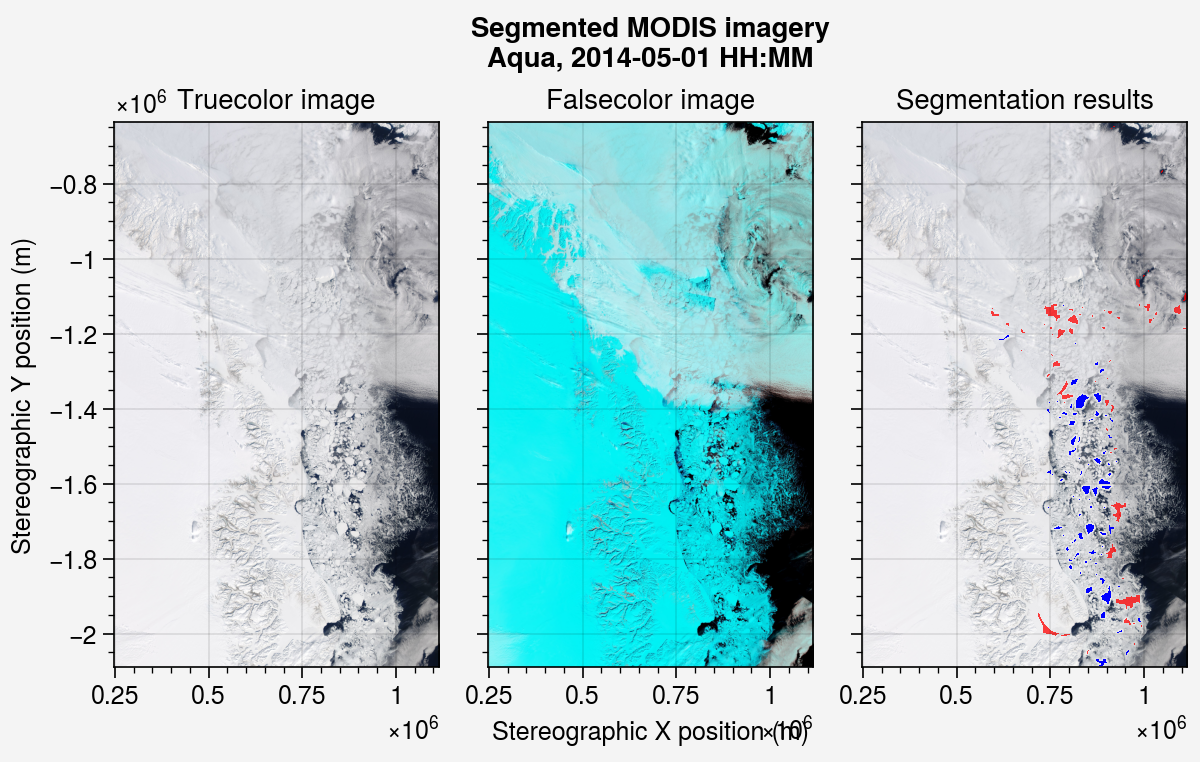

In [95]:
import rasterio as rio
import numpy as np
import proplot as pplt
from rasterio.plot import reshape_as_image

# Satellite image data is stored on the shared drive
image_loc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])


date = pd.to_datetime('2014-05-01 12:14:19')
year_folder = 'fram_strait-{y}'.format(y=date.year)
satellite = ift_all.loc[ift_all.datetime == date, 'satellite'].values[0]
tc_path = os.path.join(image_loc, year_folder,
                       get_month_folder(date),
                       'truecolor',
                       '.'.join([date.strftime('%Y%m%d'),
                                 satellite,
                                 'truecolor', '250m', 'tiff']))
lbr_path = os.path.join(image_loc, year_folder,
                       get_month_folder(date),
                       'labeled_raw',
                       '.'.join([date.strftime('%Y%m%d'),
                                 satellite,
                                 'labeled_raw', '250m', 'tiff']))
fc_path = os.path.join(image_loc, year_folder,
                       get_month_folder(date),
                       'falsecolor',
                       '.'.join([date.strftime('%Y%m%d'),
                                 satellite,
                                 'falsecolor', '250m', 'tiff']))
lbc_path = os.path.join(image_loc, year_folder,
                       get_month_folder(date),
                       'labeled_clean',
                       '.'.join([date.strftime('%Y%m%d'),
                                 satellite,
                                 'labeled_clean', '250m', 'tiff']))

with rio.open(lbr_path) as im:
    lbr = reshape_as_image(im.read())
    left, bottom, right, top = im.bounds
    
with rio.open(lbc_path) as im:
    lbc = reshape_as_image(im.read())

with rio.open(tc_path) as im:
    tc = reshape_as_image(im.read())

with rio.open(fc_path) as im:
    fc = reshape_as_image(im.read())

    
    
fig, axs = pplt.subplots(width=6, ncols=3)

axs[0].imshow(tc, extent=[left, right, bottom, top])
axs[1].imshow(fc, extent=[left, right, bottom, top])
axs[2].imshow(tc, extent=[left, right, bottom, top])
axs[2].imshow(np.ma.masked_array(lbr, lbr==0), color='r', extent=[left, right, bottom, top], alpha=0.75)
axs[2].imshow(np.ma.masked_array(lbc, lbc==0), color='b', extent=[left, right, bottom, top], alpha=1)    

axs[0].format(title='Truecolor image')
axs[1].format(title='Falsecolor image')
axs[2].format(title='Segmentation results')
h = [ax.plot([],[],color=color, alpha=0.75, lw=0, marker='s') for color in ['r', 'b']]

ax.legend(h, ['All segments', 'Clean segments'], loc='ll', ncols=1)  
axs.format(suptitle='Segmented MODIS imagery\n' + satellite.title() + ', ' + date.strftime('%Y-%m-%d HH:MM'), xlabel='Stereographic X position (m)', ylabel='Stereographic Y position (m)')
fig.save('../figures/' + date.strftime('%Y%m%d') + '-' + satellite + '-example.png', dpi=300)


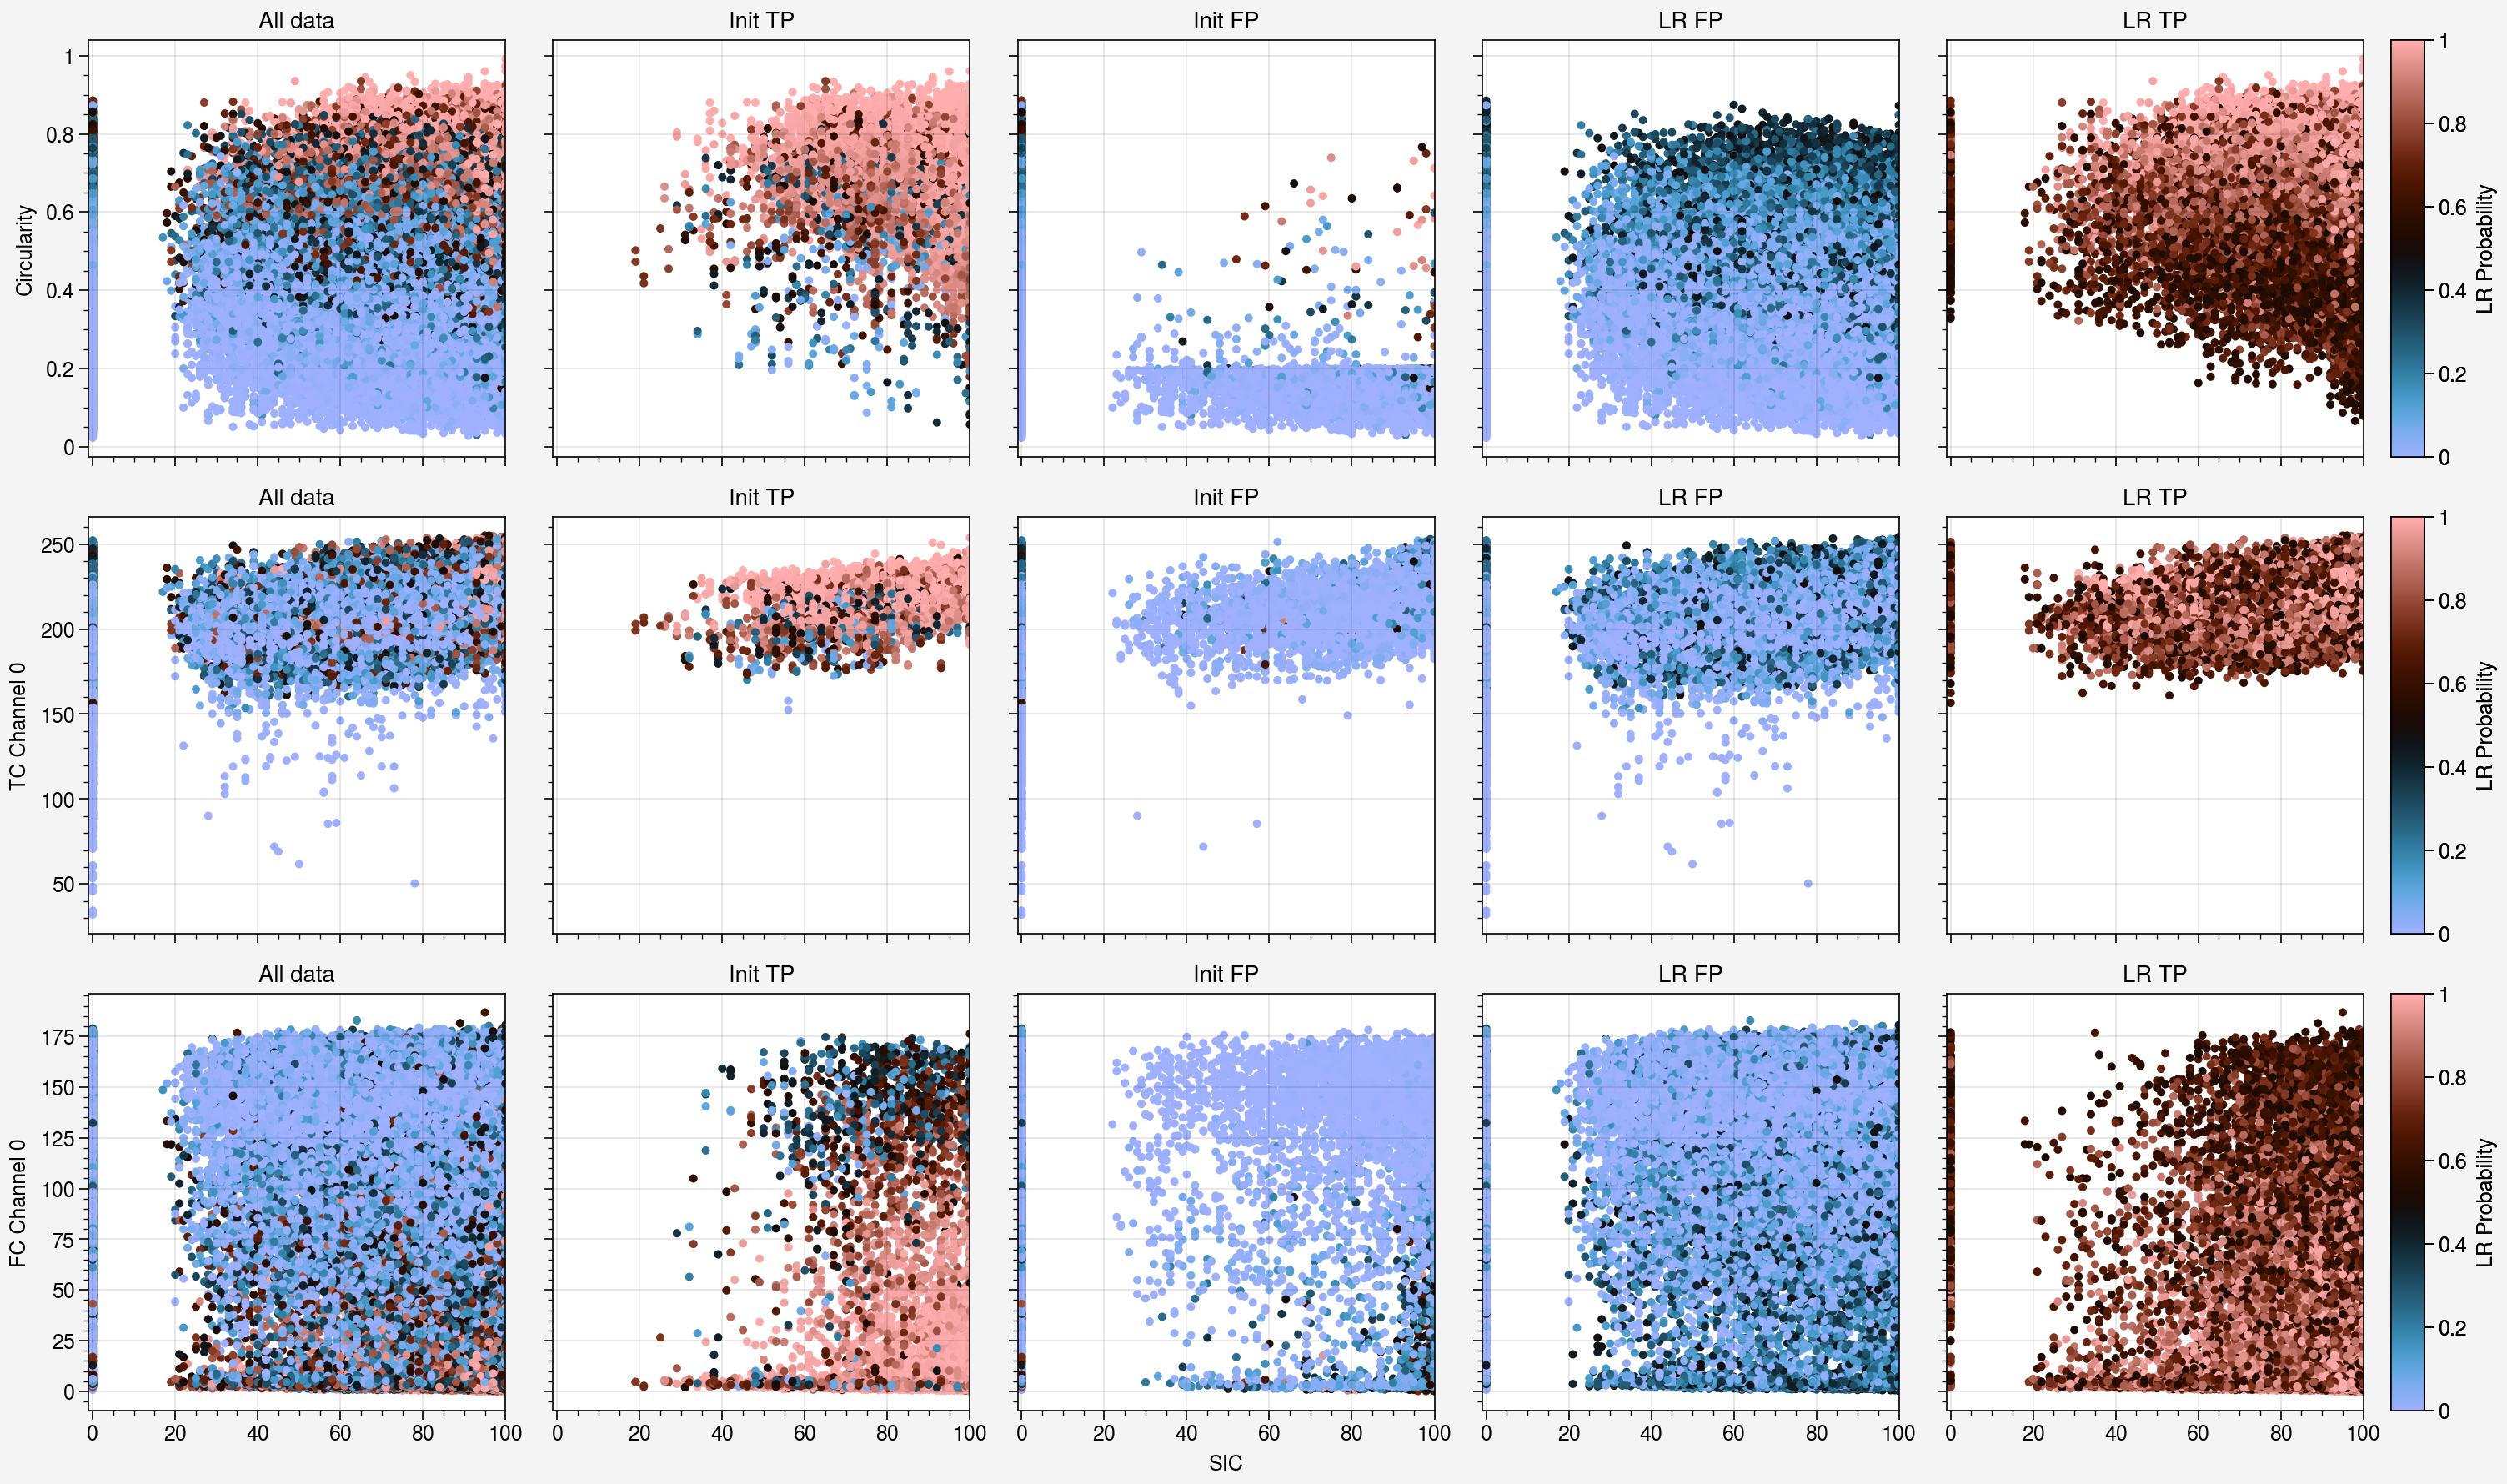

In [8]:
fig, axs = pplt.subplots(ncols=5, nrows=3, spany=False)
all_data = ift_dfs[year].index
true_positives_init = ift_dfs[year].init_classification == 'TP'
false_positives_init = ift_dfs[year].init_classification == 'FP'
lr_false_positives = ~ift_dfs[year].lr_classification.fillna(False)
lr_true_positives = ift_dfs[year].lr_classification.fillna(False)
for ax_row, ax_title, var in zip(range(3), ['Circularity', 'TC Channel 0', 'FC Channel 0'], ['circularity', 'tc_channel0', 'fc_channel0']):
    
    for ax, idx, title in zip(axs[ax_row,:], [all_data, true_positives_init, false_positives_init, lr_false_positives, lr_true_positives],
                             ['All data', 'Init TP', 'Init FP', 'LR FP', 'LR TP']):
        df = ift_dfs[year].loc[idx,:]
        c = ax.scatter(df.nsidc_sic.values * 100, df[var].values, marker='.', c=df.lr_probability, cmap='berlin', vmin=0, vmax=1)
        ax.format(xlim=(-1, 100), xlabel='SIC', title=title, ylabel=ax_title)
    ax.colorbar(c, label='LR Probability') # only do colorbar on rightmost row

In [9]:
ift_all = pd.concat(ift_dfs)

In [17]:
# precision: fraction of true positives out of the set of all objects labeled as true
n_tp = ift_all.loc[ift_all.init_classification == 'TP'].shape[0]
n_found = ift_all.loc[(ift_all.init_classification == 'TP') & ift_all.lr_classification].shape[0]
print('precision = ', np.round(n_found/n_tp))

precision =  1.0


There are still some places where the indices do not match well. It looks like an off-by-one error. It doesn't seem to apply to very many true positive floes though. I'll look into how many have large mismatches. 

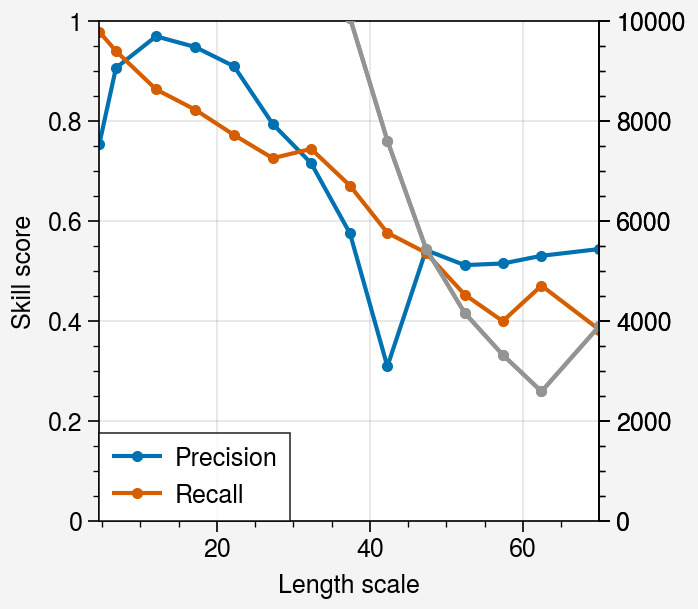

In [44]:
# logbins = np.logspace(np.log(3), np.log(200), base=np.e, num=10)
lbins = np.arange(5, 70, 5)
ift_all['L'] = np.sqrt(ift_all.area*0.25**2) # length scale
ift_all['L_bin'] = np.digitize(ift_all['L'], bins=lbins)

r_by_group = []
p_by_group = []
g_L_scale = []
n = []
for name, group in ift_all.groupby('L_bin'):
    # recall is the number of true positives out of all the true floes
    n_floes = group.loc[group.init_classification == 'TP'].shape[0]
    n_tp = group.loc[(group.init_classification == 'TP') & group.lr_classification].shape[0]
    if n_floes > 0:
        r_by_group.append(n_tp/n_floes)
    else:
        r_by_group.append(np.nan)

    # precision is the fraction of true positives out of the number labeled as floes
    n_labeled_floes = group.loc[group.lr_classification & (group.init_classification != 'UK')].shape[0]
    if n_floes > 0:
        p_by_group.append(n_tp/n_labeled_floes)
    else:
        p_by_group.append(np.nan)
    n.append(len(group.loc[group.init_classification != 'UK']))
    
    
    g_L_scale.append(group['L'].mean())
fig, ax = pplt.subplots()
ax.plot(g_L_scale, p_by_group, label='Precision', marker='.')
ax.plot(g_L_scale, r_by_group, label='Recall', marker='.')
ax2 = ax.twinx()
ax2.plot(g_L_scale, n, label='Number of floes', color='gray', marker='.')
# ax2.format(yscale='log', ylabel='Number of labeled objects')
ax.format(ylim=(0, 1), ylabel='Skill score', xlabel='Length scale')
ax2.format(ylim=(0, 10000))
ax.legend(loc='ll', ncols=1)

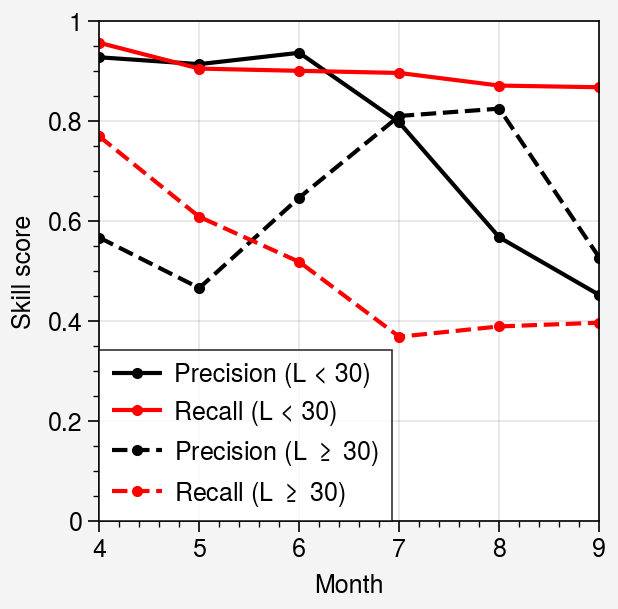

In [36]:
logbins = np.logspace(np.log(3), np.log(200), base=np.e, num=10)
ift_all['L'] = np.sqrt(ift_all.area*0.25**2) # length scale
ift_all['L_bin'] = np.digitize(ift_all['L'], bins=logbins)

r_by_group = []
p_by_group = []
month = []
ift_all['month'] = ift_all.datetime.dt.month

for name, group in ift_all.loc[(ift_all.month != 3) & (ift_all.L < 30)].groupby('month'):
    # recall is the number of true positives out of all the true floes
    n_floes = group.loc[group.init_classification == 'TP'].shape[0]
    n_tp = group.loc[(group.init_classification == 'TP') & group.lr_classification].shape[0]
    if n_floes > 0:
        r_by_group.append(n_tp/n_floes)
    else:
        r_by_group.append(np.nan)

    # precision is the fraction of true positives out of the number labeled as floes
    n_labeled_floes = group.loc[group.lr_classification & (group.init_classification != 'UK')].shape[0]
    if n_floes > 0:
        p_by_group.append(n_tp/n_labeled_floes)
    else:
        p_by_group.append(np.nan)
    month.append(name)
fig, ax = pplt.subplots()
ax.plot(month, p_by_group, label='Precision (L < 30)', marker='.', color='k')
ax.plot(month, r_by_group, label='Recall (L < 30)', marker='.', color='r')

r_by_group = []
p_by_group = []
month = []

for name, group in ift_all.loc[(ift_all.month != 3) & (ift_all.L >= 30)].groupby('month'):
    # recall is the number of true positives out of all the true floes
    n_floes = group.loc[group.init_classification == 'TP'].shape[0]
    n_tp = group.loc[(group.init_classification == 'TP') & group.lr_classification].shape[0]
    if n_floes > 0:
        r_by_group.append(n_tp/n_floes)
    else:
        r_by_group.append(np.nan)

    # precision is the fraction of true positives out of the number labeled as floes
    n_labeled_floes = group.loc[group.lr_classification & (group.init_classification != 'UK')].shape[0]
    if n_floes > 0:
        p_by_group.append(n_tp/n_labeled_floes)
    else:
        p_by_group.append(np.nan)
    month.append(name)
ax.plot(month, p_by_group, label='Precision (L $\geq$ 30)', marker='.', ls='--', color='k')
ax.plot(month, r_by_group, label='Recall (L $\geq$ 30)', marker='.', ls='--', color='r')

ax.format(ylim=(0, 1), ylabel='Skill score', xlabel='Month')
ax.legend(loc='ll', ncols=1)

In [5]:
print('1st (99th) percentile floe area (pixels)')
for year in ift_dfs:
    print(year,
          ift_dfs[year].area.quantile([0.01]).values[0].astype(int),
          ift_dfs[year].area.quantile([0.99]).values[0].astype(int),
          )

1st (99th) percentile floe area (pixels)
2003 304 8294
2004 303 6634
2005 303 6933
2006 303 6025
2007 303 7510
2008 303 8798
2009 303 9065
2010 303 6954
2011 303 5079
2012 304 7019
2013 303 8189
2014 304 7720
2015 303 5738
2016 303 7128
2017 304 8911
2018 303 6322
2019 303 9341
2020 302 8130


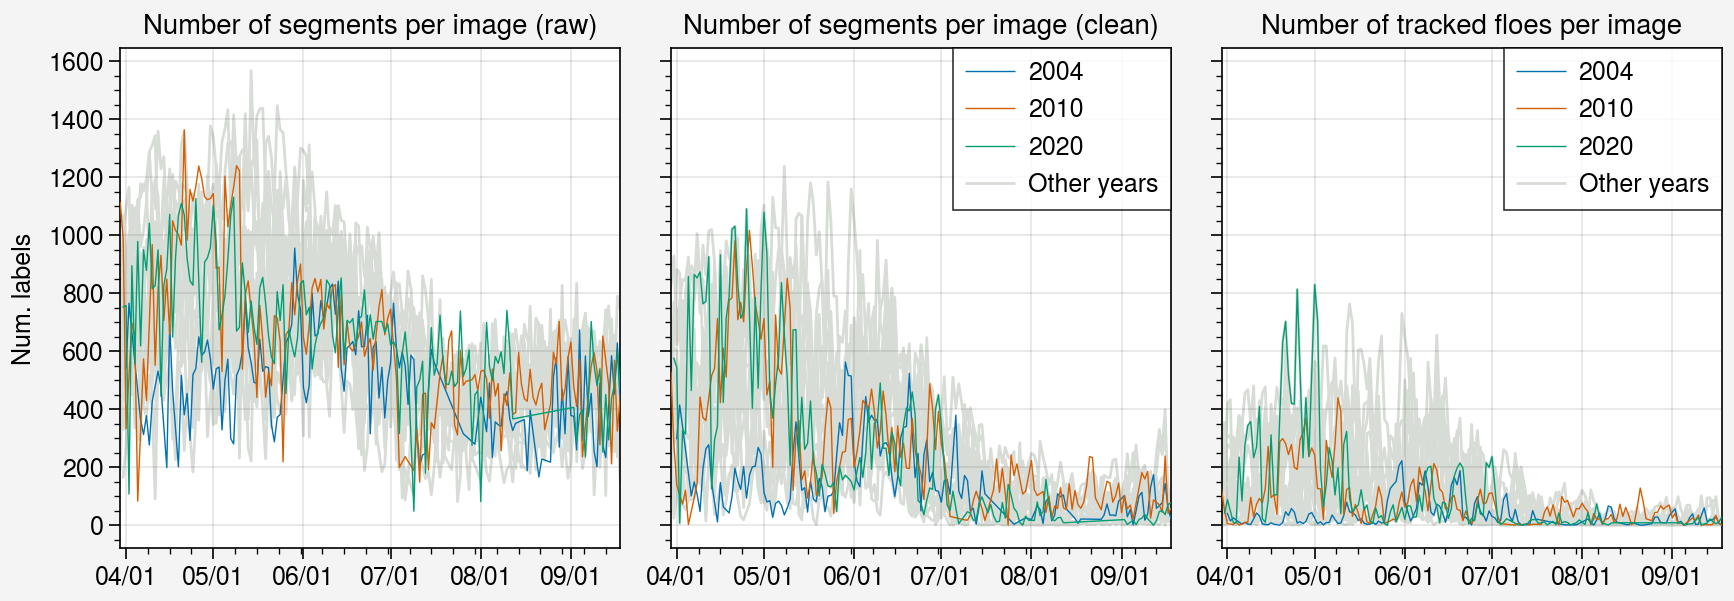

In [18]:
import warnings
warnings.simplefilter('ignore')
fig, ax = pplt.subplots(ncols=3)
for year in ift_dfs:
    dftest = ift_dfs[year].loc[(ift_dfs[year].area_matlab >= 300)]
    dates = pd.to_datetime(pd.to_timedelta(dftest.groupby(dftest.datetime.dt.dayofyear).count().index - 1, unit='day') + pd.to_datetime('{y}-01-01'.format(y=year)))
    if year in [2004, 2010, 2020]:
        ax[0].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=0.5, marker='', label=year, zorder=20)
    else:
        ax[0].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='', color='light gray', zorder=0)
dates = pd.date_range('{y}-04-01'.format(y=year),
                       '{y}-10-01'.format(y=year), freq='1MS')
ax.format(xformatter=[d.strftime('%m/%d') for d in dates], xlocator=[d.dayofyear for d in dates], xlabel='', ylabel='Num. labels')
ax[0].format(title='Number of segments per image (raw)')

for year in ift_dfs:
    dftest = ift_dfs[year].loc[ift_dfs[year].final_classification]
    dates = pd.to_datetime(pd.to_timedelta(dftest.groupby(dftest.datetime.dt.dayofyear).count().index - 1, unit='day') + pd.to_datetime('{y}-01-01'.format(y=year)))
    if year in [2004, 2010, 2020]:
        ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=0.5, marker='', label=year, zorder=20)
    else:
        ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='', color='light gray', zorder=0)
ax[1].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='Other years', color='light gray', zorder=0)        
dates = pd.date_range('{y}-04-01'.format(y=year),
                       '{y}-10-01'.format(y=year), freq='1MS')
ax.format(xformatter=[d.strftime('%m/%d') for d in dates], xlocator=[d.dayofyear for d in dates], xlabel='', ylabel='Num. labels')
ax[1].legend(loc='ur', ncols=1)
ax[1].format(title='Number of segments per image (clean)')

for year in ift_dfs:
    dftest = ift_dfs[year].loc[(ift_dfs[year].area_matlab >= 300) & (ift_dfs[year].floe_id != 'unmatched')]
    dates = pd.to_datetime(pd.to_timedelta(dftest.groupby(dftest.datetime.dt.dayofyear).count().index - 1, unit='day') + pd.to_datetime('{y}-01-01'.format(y=year)))
    if year in [2004, 2010, 2020]:
        ax[2].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=0.5, marker='', label=year, zorder=20)
    else:
        ax[2].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='', color='light gray', zorder=0)
ax[2].plot(dftest.groupby(dftest.datetime.dt.dayofyear).count()['label'], lw=1, marker='', label='Other years', color='light gray', zorder=0)        
dates = pd.date_range('{y}-04-01'.format(y=year),
                       '{y}-10-01'.format(y=year), freq='1MS')
ax.format(xformatter=[d.strftime('%m/%d') for d in dates], xlocator=[d.dayofyear for d in dates], xlabel='', ylabel='Num. labels')
ax[2].legend(loc='ur', ncols=1)
ax[2].format(title='Number of tracked floes per image')
# ax.format(yscale='log')

How does the number of data points for training the LR model change over time?

2003 50701.0
2004 24027.0
2005 42380.0
2006 28408.0
2007 46071.0
2008 53856.0
2009 46816.0
2010 43997.0
2011 39962.0
2012 52416.0
2013 48892.0
2014 53974.0
2015 38667.0
2016 47412.0
2017 59384.0
2018 31768.0
2019 43734.0
2020 43181.0


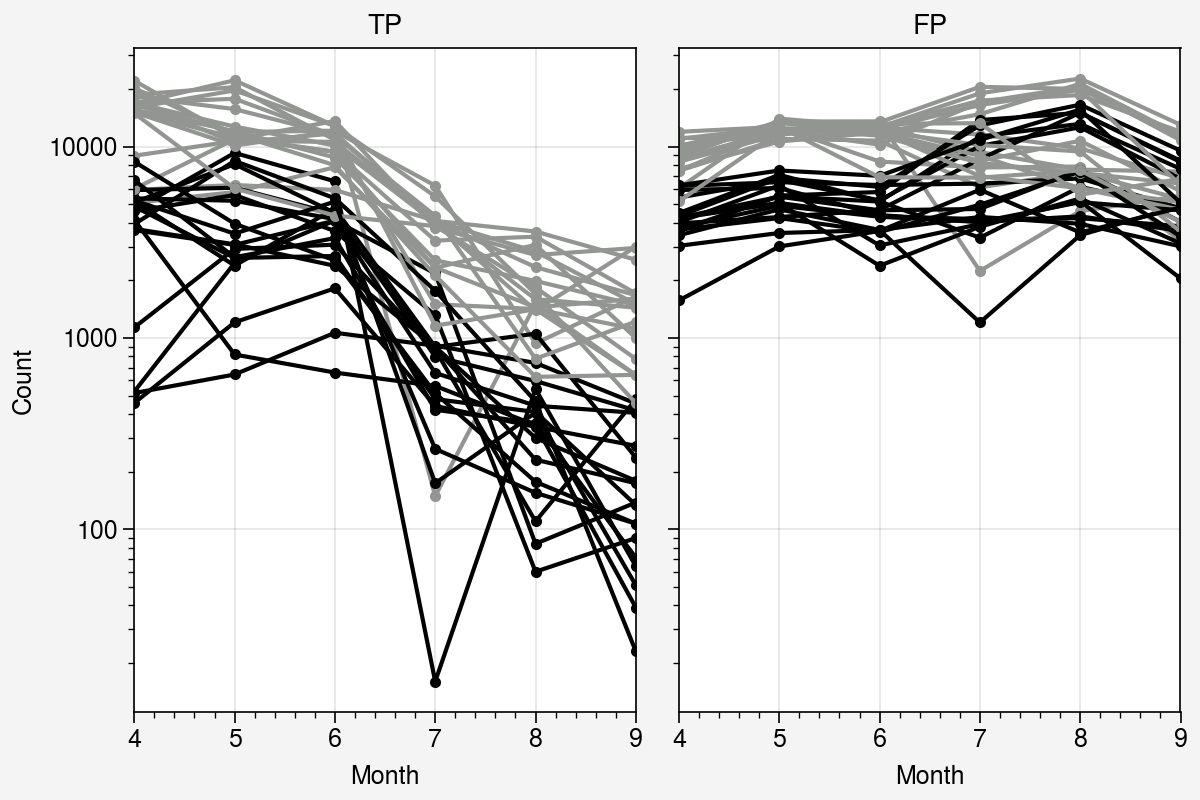

In [26]:
import warnings
warnings.simplefilter('ignore')
fig, axs = pplt.subplots(width=6, height=4, ncols=2, spanx=False)
for cls, ax in zip(['TP', 'FP'], axs):
    for year in ift_dfs:
        
        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        if cls == 'TP':
            print(year, summary.loc[True, :].sum())
        ax.plot(summary.columns, summary.loc['T' in cls,:], marker='.', color='gray')
        
        summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'init_classification']
                     ).count()[['floe_id']].pivot_table(index='init_classification', values='floe_id', columns='datetime').fillna(0)
        summary = summary.loc[:, summary.columns > 3]
        ax.plot(summary.columns, summary.loc[cls,:], marker='.', color='k')

        ax.format(ylabel='Count', title=cls, xlabel='Month')
        ax.format(yscale='log')

In [164]:
summary = ift_dfs[year].groupby([ift_dfs[year].datetime.dt.month, 'lr_classification']
                     ).count()[['floe_id']].pivot_table(index='lr_classification', values='floe_id', columns='datetime').fillna(0)
year

2020

In [14]:
def pixel_path_length(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_pixel'] - floe_df['x_pixel'].shift(-1)
    delta_y = floe_df['y_pixel'] - floe_df['y_pixel'].shift(-1)
    return (np.sqrt(delta_x**2 + delta_y**2)).sum()

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)

(array([5.541e+03, 8.720e+02, 9.560e+02, 3.050e+02, 2.740e+02, 1.360e+02,
        1.210e+02, 6.700e+01, 6.200e+01, 4.500e+01, 5.300e+01, 2.100e+01,
        9.000e+00, 9.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 4.000e+00]),
 array([ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5, 11.5,
        12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 18 artists>)

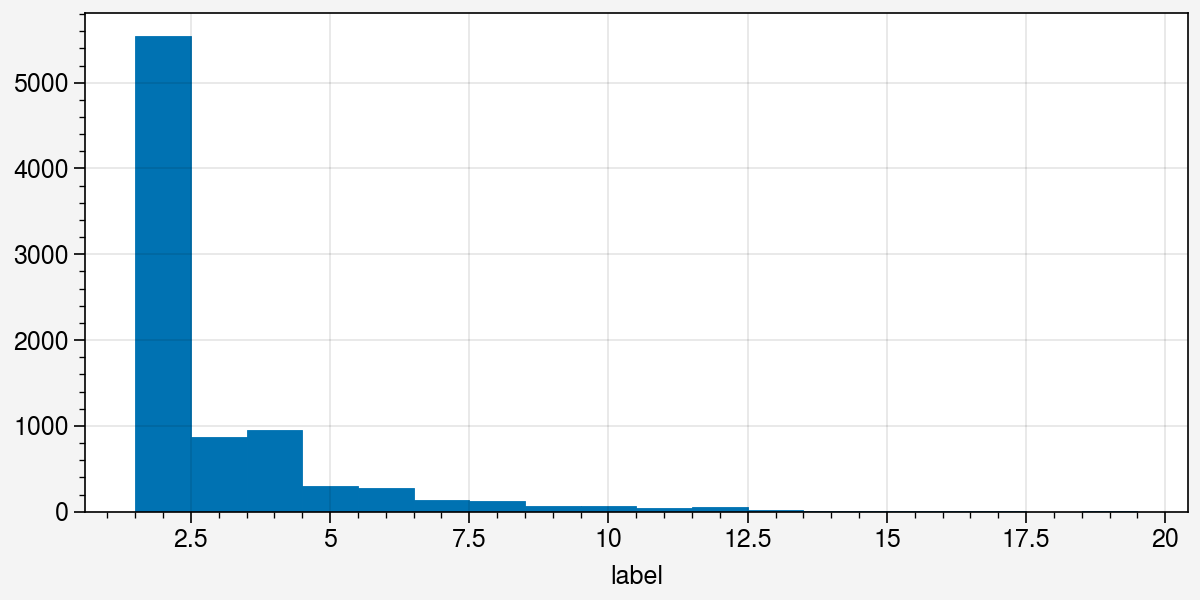

In [15]:
fig, ax = pplt.subplots(width=6, height=3)
ax.hist(ift_dfs[2020].loc[ift_dfs[2020].floe_id != 'unmatched'].groupby('floe_id').count()['label'], bins=np.arange(1.5, 20))

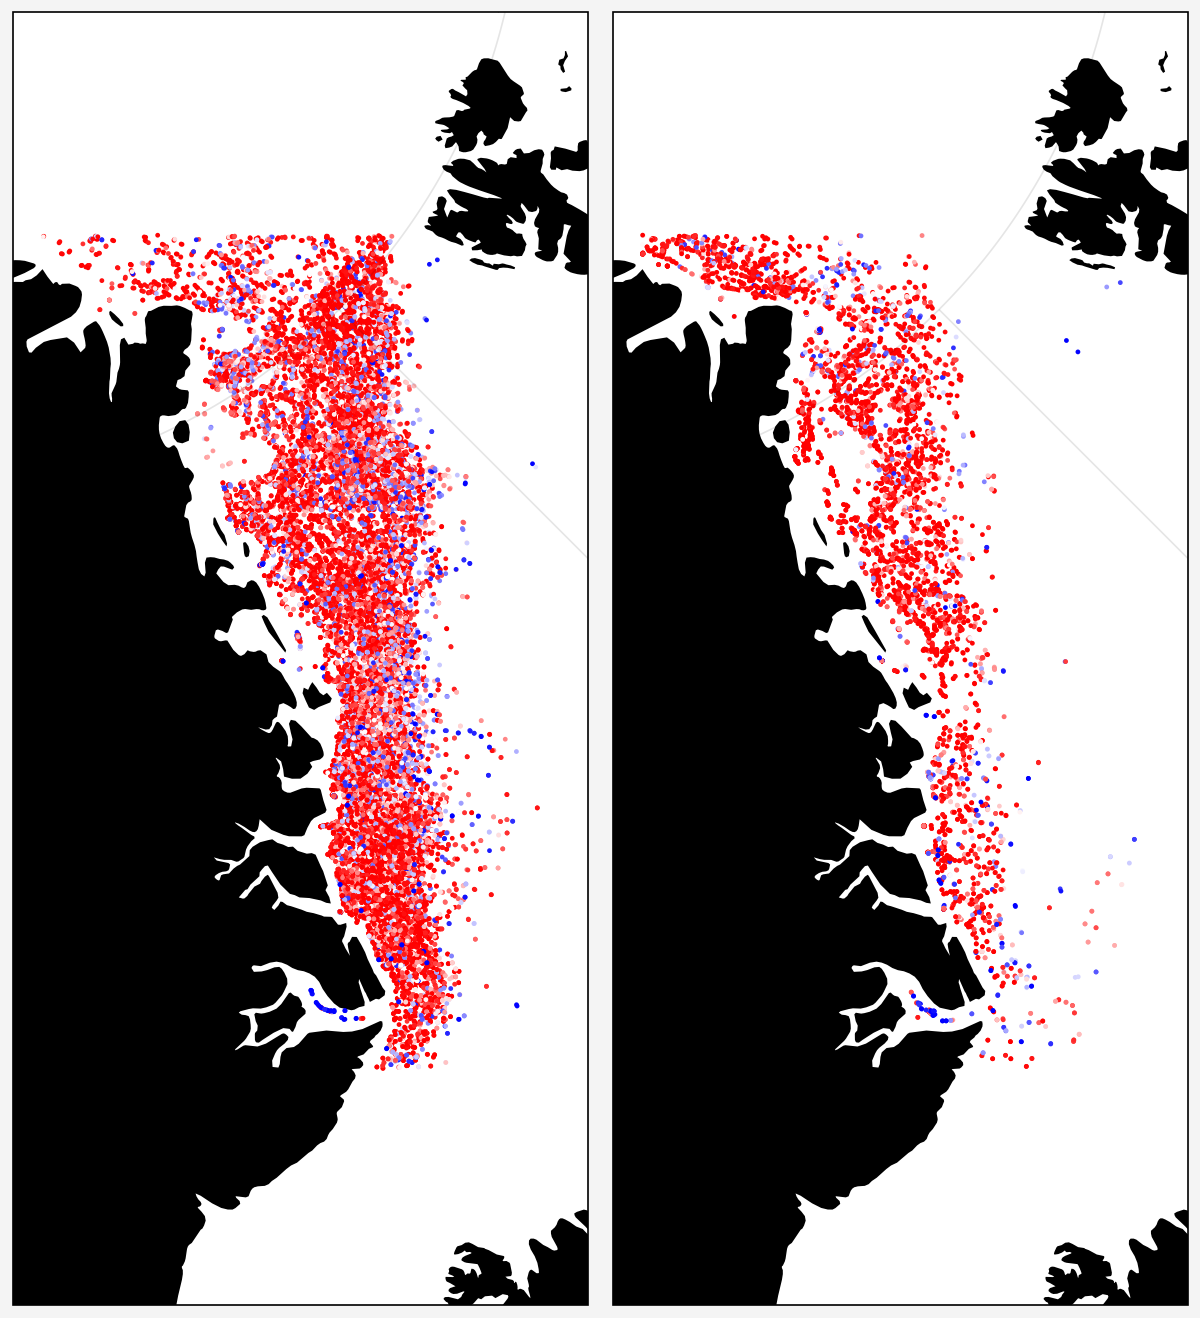

In [61]:
import cartopy.crs as ccrs
pplt.rc['cartopy.circular'] = False
pplt.rc['reso'] = 'med'
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)

fig, axs = pplt.subplots(width=6, proj='npstere', proj_kw={'lon_0': -45}, ncols=2)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.25e6], crs=crs)
for year, ax in zip([2003, 2004], axs):
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    ax.scatter(df.x_stere.values, df.y_stere.values, marker='.', ms=5, c=df.lr_probability, cmap='bwr', transform=crs)


In [153]:
est_speeds = {}
for year in ift_dfs:
    df = ift_dfs[year].loc[ift_dfs[year].floe_id != 'unmatched']
    est_speeds[year] = df.groupby('floe_id').apply(estimated_mean_speed)

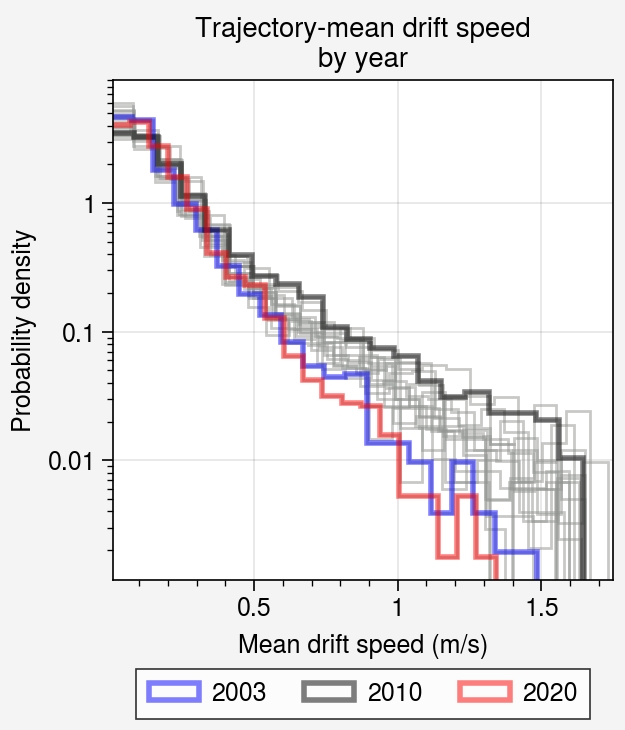

In [159]:
fig, ax = pplt.subplots()
for year in est_speeds:
    ax.hist(est_speeds[year].loc[est_speeds[year] < 10], bins=20,
            alpha=0.5, label='', density=True, histtype='step', lw=1, color='gray')

ax.format(yscale='log', xlim=(0.01, 1.75))
for color, year in zip(['b', 'k', 'r'], [2003, 2010, 2020]):
    ax.hist(est_speeds[year].loc[est_speeds[year] < 10], bins=20,
            alpha=0.5, label=year, density=True, histtype='step', lw=2, color=color)
ax.legend(loc='b')    
ax.format(title='Trajectory-mean drift speed\nby year',
          xlabel='Mean drift speed (m/s)', ylabel='Probability density')

Our next challenge is to investigate the cause of the mismatch in the estimated floe shapes. This will help us find out where the property tables and the floe libraries are not in the same order. For example, it may be that on some days the data from aqua and terra are processed in a different order.

Another possibility is that the shapes are pretty accurate, but that the method for area calculation for the wonky cloud shapes is different.

We'll look at this by choosing a specific date that contains a large difference in area.

In [28]:

df = ift_dfs[2020].copy()
df['area_mismatch'] = df['area'] - df['area_matlab']
df['perimeter_mismatch'] = df['perimeter'] - df['perimeter_matlab']

In [67]:
df.loc[np.abs(df.area - df.area_matlab) > 20000, ['datetime', 'label', 'area', 'area_matlab', 'area_mismatch', 'perimeter', 'perimeter_matlab']].sort_values('area_mismatch')[::-1]


datetime  label      area  area_matlab  area_mismatch  \
84322  2020-05-22 13:49:26    189  112507.0      83844.0        28663.0   
45054  2020-04-28 11:43:13    697   21424.0        260.0        21164.0   
44581  2020-04-27 13:55:36    197   21364.0        777.0        20587.0   
108713 2020-06-09 13:37:10    471   20658.0        277.0        20381.0   
5899   2020-04-04 13:49:46    228   38538.0      58564.0       -20026.0   
...                    ...    ...       ...          ...            ...   
43779  2020-04-27 12:38:20    318   26051.0      68332.0       -42281.0   
44502  2020-04-27 13:55:36    108   26955.0      72636.0       -45681.0   
45323  2020-04-28 11:43:13    356   27758.0      74273.0       -46515.0   
108090 2020-06-09 12:19:48    162   34469.0      83285.0       -48816.0   
108913 2020-06-09 13:37:10    253   35198.0      84369.0       -49171.0   

        perimeter  perimeter_matlab  
84322      2902.2          4632.776  
45054       764.5            65.616  
44581      1022.5           114.924  
108713      923.7            70.570  
5899       1342.2          1560.312  
...           ...               ...  
43779      1547.5          1515.358  
44502      1688.3          1558.050  
45323      1513.9          1493.412  
108090     2292.4          2277.042  
108913     2170.2          2118.112  

[454 rows x 7 columns]

In [46]:
date = '2020-05-22 13:49:26'
df_test = df.loc[df.datetime == date].copy()


In [59]:
comparison_index = 84322
variables = ['area', 'area_matlab', 'perimeter', 'perimeter_matlab']
df_diff = df_test.loc[:, variables] - df_test.loc[comparison_index, 'perimeter_matlab']

In [60]:
np.abs(df_diff).sort_values('perimeter')

area  area_matlab  perimeter  perimeter_matlab
84322  107874.224    79211.224   1730.576             0.000
83873   49020.224    74634.224   2475.776          2109.850
84180   41915.224    66015.224   2903.676          2591.962
84069   19903.224    30717.224   2959.976          2673.946
84179   31781.224    50712.224   3212.876          2938.890
...           ...          ...        ...               ...
83900    4507.776     4425.776   4591.576          4581.368
83902    4508.776     4423.776   4591.776          4580.930
83915    4506.776     4422.776   4591.776          4581.856
84080    4518.776     4423.776   4592.076          4579.822
83898    4596.776     1863.776   4600.776          4320.592

[550 rows x 4 columns]

In [25]:
trajectories = {}
for year in range(2003, 2021):
    trajectories[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_interp_floe_trajectories_{y}.csv'.format(y=year), index_col=0)


/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


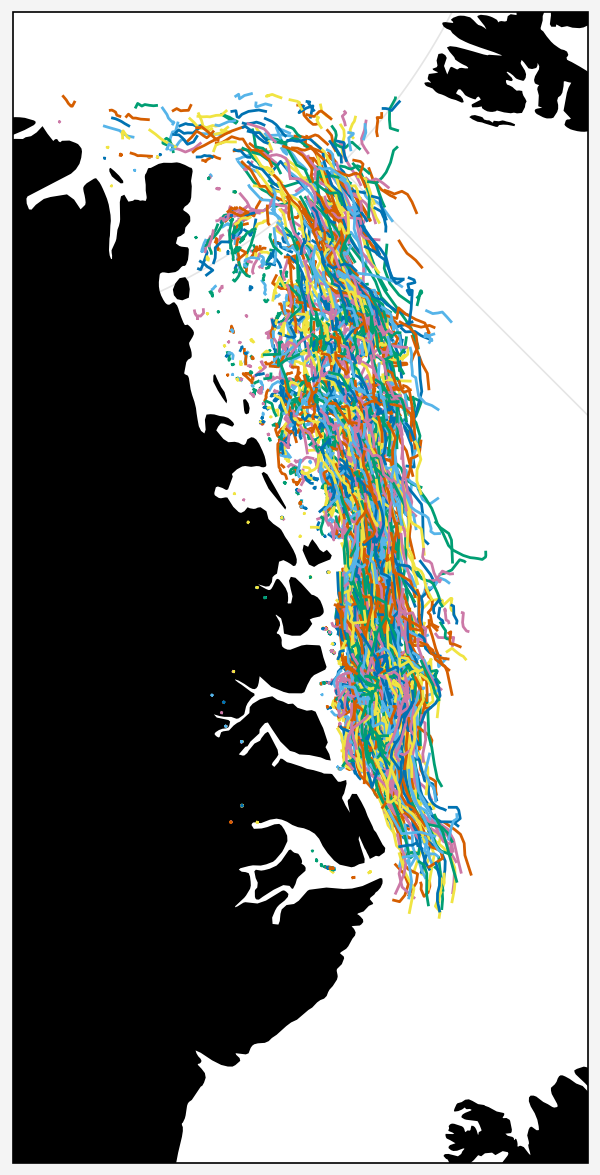

In [46]:
fig, axs = pplt.subplots(width=3, proj='npstere', proj_kw={'lon_0': -45}, ncols=1)
axs.format(land=True, landzorder=0)
axs.set_extent([0.2e6, 1.2e6, -2.5e6, -0.5e6], crs=crs)
for year in trajectories:
    df = trajectories[year]
    for floe_id, group in df.groupby('floe_id'):
        if floe_id != 'unmatched':
            if len(group) > 5:
                axs.plot(group.x_stere.values, group.y_stere.values, transform=crs, marker='', lw=1)

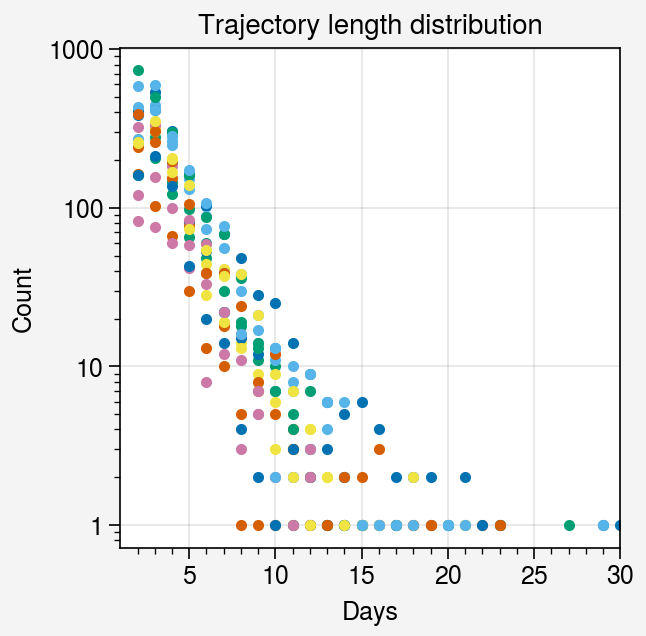

In [48]:
fig, ax = pplt.subplots()
for year in trajectories:
    df = trajectories[year]
    data, bins = np.histogram(df.groupby('floe_id').apply(lambda x: len(x), include_groups=False), bins=np.arange(1.5, 45, 1))
    lengths = np.arange(2, 45)
    ax.plot(lengths, data, marker='.', lw=0)
    ax.format(yscale='log')
ax.format(title='Trajectory length distribution', ylabel='Count', xlabel='Days')
ax.format(xlim=(1, 30))

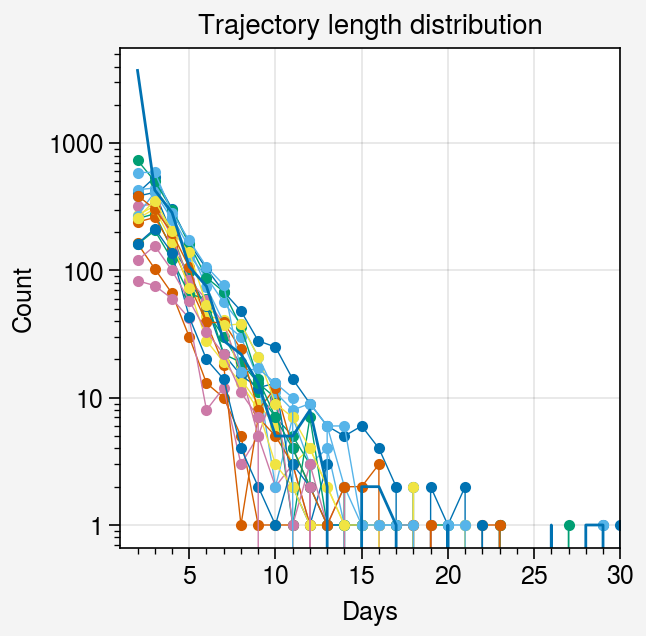

In [74]:
fig, ax = pplt.subplots()
for year in trajectories:
    df = trajectories[year]
    data, bins = np.histogram(df.groupby('floe_id').apply(lambda x: len(x), include_groups=False), bins=np.arange(1.5, 45, 1))
    lengths = np.arange(2, 45)
    ax.plot(lengths, data, marker='.', lw=0.5)
    ax.format(yscale='log')
data, bins = np.histogram(df_data2.loc[df_data2.floe_id != 'unmatched'].groupby('floe_id').apply(lambda x: len(x)), bins=np.arange(1.5, 45, 1))
ax.plot(lengths, data, lw=1)
ax.format(title='Trajectory length distribution', ylabel='Count', xlabel='Days')
ax.format(xlim=(1, 30))

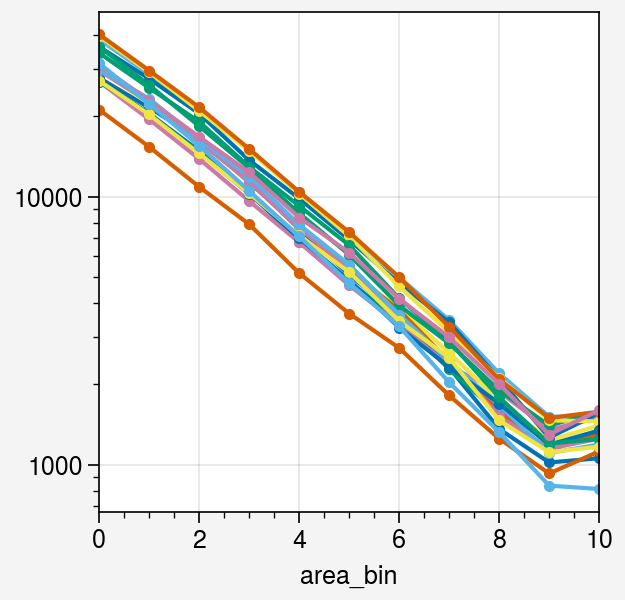

In [34]:
logbins = np.logspace(np.log(30), np.log(2000), base=np.e, num=10)
fig, ax = pplt.subplots()
for year in ift_dfs:
    ift_dfs[year]['area_km'] = ift_dfs[year]['area']*0.25**2
    ift_dfs[year]['area_bin'] = np.digitize(ift_dfs[year]['area_km'], bins=logbins)
    ax.plot(ift_dfs[year][['area', 'area_bin']].groupby('area_bin').count(), marker='.')
    ax.format(yscale='log')

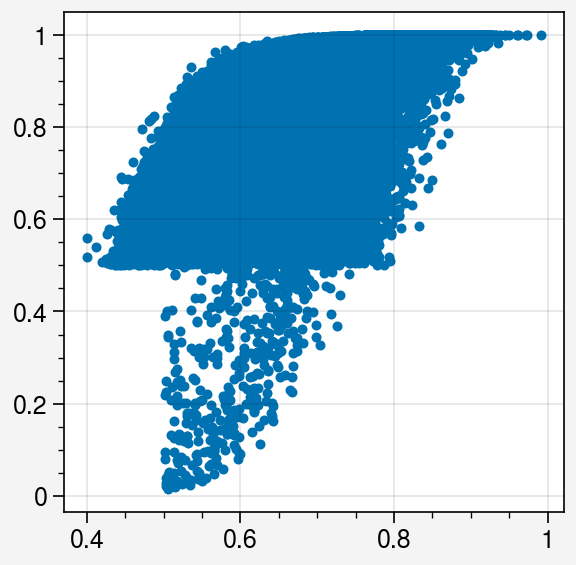

In [25]:
fig, ax = pplt.subplots()
ax.scatter(ift_dfs[year]['circularity'].values,
           ift_dfs[year]['lr_probability'].values, marker='.')

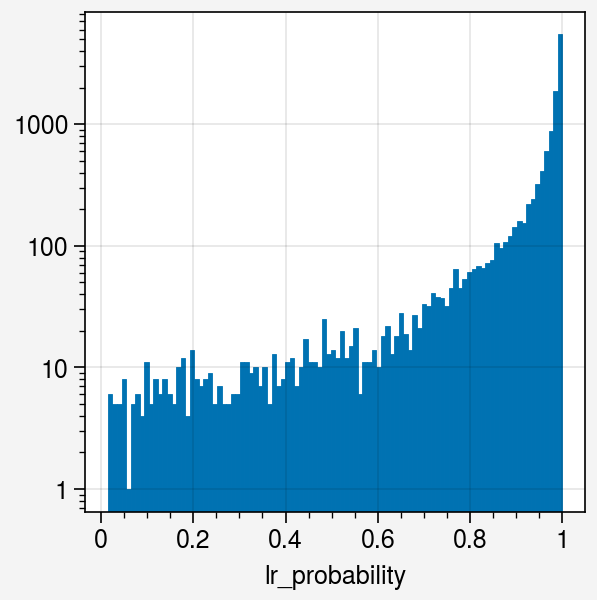

In [31]:
fig, ax = pplt.subplots()
_ = ax.hist(ift_dfs[year].loc[ift_dfs[year]['init_classification'] == 'TP', 'lr_probability'], bins=100)
ax.format(yscale='log')

In [34]:
ift_dfs[2015]

Unnamed: 0            datetime satellite    floe_id  label  longitude  \
0               3 2015-04-01 12:48:38     terra  unmatched    110   -12.7338   
1               4 2015-04-01 12:48:38     terra  unmatched    111   -15.9497   
2               5 2015-04-01 12:48:38     terra  unmatched    112   -14.1843   
3               6 2015-04-01 12:48:38     terra  unmatched    113   -15.6240   
4               7 2015-04-01 12:48:38     terra  unmatched    115   -18.9672   
...           ...                 ...       ...        ...    ...        ...   
32435       93890 2015-09-18 12:07:24      aqua  unmatched     19   -17.7256   
32436       93895 2015-09-18 12:07:24      aqua  unmatched     14    -6.7382   
32437       93935 2015-09-18 12:07:24      aqua  unmatched    107     4.2702   
32438       93949 2015-09-18 12:07:24      aqua  unmatched     74   -16.8949   
32439       93970 2015-09-18 12:07:24      aqua  unmatched    289    -7.6097   

       latitude    x_stere    y_stere    col_pixel  ...  tc_channel1  \
0       74.6690   891722.7 -1412410.0  2515.673179  ...        209.4   
1       73.1055   894908.4 -1611117.4  2528.117162  ...        217.0   
2       73.8890   899758.2 -1508420.2  2547.061728  ...        208.4   
3       73.0765   905626.0 -1608801.9  2569.982713  ...        220.0   
4       70.5488   933399.3 -1910979.3  2678.472081  ...        222.6   
...         ...        ...        ...          ...  ...          ...   
32435   79.5272   521276.8 -1011064.2  1068.618868  ...        225.6   
32436   82.4770   505355.6  -640768.1  1006.426434  ...        243.7   
32437   80.7012   764952.5  -658656.2  2020.476744  ...        232.3   
32438   76.5242   690755.1 -1293391.5  1730.643293  ...        196.8   
32439   73.2737  1107833.9 -1449495.7  3359.857488  ...        202.3   

       tc_channel2  fc_channel0  fc_channel1  fc_channel2  \
0            211.6         65.4        218.3        225.0   
1            219.2         10.8        225.9        231.8   
2            211.6          8.4        215.7        222.9   
3            221.7         13.0        228.2        233.6   
4            227.3          5.2        227.4        234.7   
...            ...          ...          ...          ...   
32435        226.1         72.0        228.9        236.5   
32436        235.3         99.0        239.8        246.8   
32437        230.7        133.9        233.3        240.0   
32438        190.9         27.4        206.3        214.1   
32439        202.6        153.6        219.7        219.0   

       init_classification  lr_probability  lr_classification  area_km  \
0                       NA           0.829               True  35.1875   
1                       NA           0.988               True  37.8750   
2                       NA           0.739               True  25.3125   
3                       NA           0.920               True  47.0000   
4                       NA           0.597               True  24.6250   
...                    ...             ...                ...      ...   
32435                   NA           0.530               True  33.1250   
32436                   NA           0.954               True  75.1875   
32437                   NA           0.819               True  37.6250   
32438                   NA           0.987               True  20.5000   
32439                   FP           0.676               True  25.8750   

       area_bin  
0             3  
1             4  
2             3  
3             4  
4             3  
...         ...  
32435         3  
32436         5  
32437         4  
32438         2  
32439         3  

[32440 rows x 40 columns]

In [40]:
import pandas as pd
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

ift_dfs = {}
for year in range(2003, 2010):
    ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))
    ift_dfs[year]['init_classification'] = ift_dfs[year]['init_classification'].fillna('NA')
    ift_dfs[year]['datetime'] = pd.to_datetime(ift_dfs[year].datetime.values)
    
check_y, check_x = -1996809,744026

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_16369/2603329475.py:6: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  ift_dfs[year] = pd.read_csv(dataloc + 'fram_strait-{y}/ift_raw_floe_properties_{y}.csv'.format(y=year))


In [17]:
date = '2003-05-13 14:08:02'
df = ift_dfs[2003].copy()
df = df.loc[df.datetime == date]

In [19]:
d = ((df.x_stere - check_x)**2 + (df.y_stere - check_y)**2)**0.5
print(d.min())
df.loc[d < 14e3, ['x_stere', 'y_stere', 'area', 'circularity', 'tc_channel0', 'fc_channel0', 'lr_probability']]

13532.833523323854


x_stere    y_stere     area  circularity  tc_channel0  fc_channel0  \
38211  754616.1 -1988383.6  28219.0          0.2        235.8          0.9   

       lr_probability  
38211           0.175

In [20]:
df.loc[38211,:]

Unnamed: 0                           38211
datetime               2003-05-13 14:08:02
satellite                            terra
floe_id                         2003_01581
label                                  125
longitude                         -24.2176
latitude                           70.5487
x_stere                           754616.1
y_stere                         -1988383.6
col_pixel                      1980.100181
row_pixel                      5282.188065
area                               28219.0
perimeter                           1332.2
solidity                          0.416824
orientation                        1.12046
circularity                            0.2
axis_major_length                    524.2
axis_minor_length                    185.9
bbox_min_row                          5089
bbox_min_col                          1807
bbox_max_row                          5367
bbox_max_col                          2260
area_matlab                        28219.0
perimeter_m

0.3911167245782725
0.012


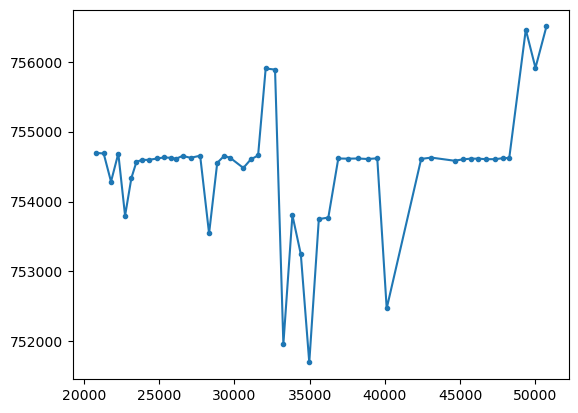

In [29]:
import numpy as np
def pixel_path_length(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['col_pixel'] - floe_df['col_pixel'].shift(-1)
    delta_y = floe_df['row_pixel'] - floe_df['row_pixel'].shift(-1)
    return (np.sqrt(delta_x**2 + delta_y**2)).median()

def estimated_mean_speed(floe_df):
    """Calculates distance traversed in units of pixels"""
    delta_x = floe_df['x_stere'] - floe_df['x_stere'].shift(-1)
    delta_y = floe_df['y_stere'] - floe_df['y_stere'].shift(-1)
    dt = (floe_df['datetime'].max() - floe_df['datetime'].min()).total_seconds()
    return np.round((np.sqrt(delta_x**2 + delta_y**2)).sum()/dt, 3)
floe_df = ift_dfs[2003].loc[ift_dfs[2003].floe_id == '2003_01581']
floe_df.x_stere.plot(marker='.')
print(pixel_path_length(floe_df))
print(estimated_mean_speed(floe_df))

In [44]:
pls = ift_dfs[2009].groupby('floe_id').apply(pixel_path_length)

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_16369/2075811523.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the ope

In [45]:
pls.quantile([0.01, 0.99])

0.01     0.075154
0.99    78.172995
dtype: float64

In [1]:
import rasterio as rio

In [2]:
ds = rio.open('/Users/dwatkin2/Downloads/segmentation_output/2000-02-29_60_terra_final.tif')

In [7]:
left_x, bottom_y, right_x, top_y = ds.bounds

In [4]:
import pyproj

In [8]:
crs0 = pyproj.CRS('epsg:3413')
crs1 = pyproj.CRS('WGS84')
transformer_ll = pyproj.Transformer.from_crs(crs0, crs_to=crs1, always_xy=True)
top_left_lon, top_left_lat = transformer_ll.transform(left_x, top_y)
lower_right_lon, lower_right_lat = transformer_ll.transform(right_x, bottom_y)
top_right_lon, top_right_lat = transformer_ll.transform(right_x, top_y)
lower_left_lon, lower_left_lat = transformer_ll.transform(left_x, bottom_y)


In [9]:
print((top_left_lon, top_left_lat))
print((lower_right_lon, lower_right_lat))
print((top_right_lon, top_right_lat))
print((lower_left_lon, lower_left_lat))


(-152.98919071434764, 67.62360839388072)
(-114.82196500940142, 78.9423506716254)
(-168.90406813248347, 77.50514464351912)
(-124.9318737392656, 68.36705241968166)


1172310.6623683888

In [ ]:

year = 2003
date = pd.to_datetime('2003-04-16 11:27:20')
dataloc = '/Volumes/Research/ENG_Wilhelmus_Shared/group/IFT_fram_strait_dataset/'

def get_month_folder(date):
    """Simple utility for navigating file structure"""
    start = '{y}{m}01'.format(y=date.year,
                              m=str(date.month).zfill(2))
    end = '{y}{m}01'.format(y=date.year,
                              m=str(date.month + 1).zfill(2))
    if (date.month == 3) | (date.month == 4):
        start = '{y}0331'.format(y=date.year)
        end = '{y}0501'.format(y=date.year)
    
    return '-'.join(['fram_strait', start, end])

satellite_image = rio.open(dataloc + 'fram_strait-{y}/'.format(y=year) + get_month_folder(date) + \
                          '/truecolor/' + '{d}.aqua.truecolor.250m.tiff'.format(d=date.strftime('%Y%m%d')))
satellite_image_fc = rio.open(dataloc + 'fram_strait-{y}/'.format(y=year) + get_month_folder(date) + \
                          '/falsecolor/' + '{d}.aqua.falsecolor.250m.tiff'.format(d=date.strftime('%Y%m%d')))

labeled_image = rio.open(dataloc + 'fram_strait-{y}/'.format(y=year) + get_month_folder(date) + \
                          '/labeled_raw/' + '{d}.aqua.labeled_raw.250m.tiff'.format(d=date.strftime('%Y%m%d')))

fig, ax = pplt.subplots(ncols=3, share=False)

left, bottom, right, top = satellite_image.bounds
ax[0].imshow(reshape_as_image(satellite_image.read()), extent=[left, right, bottom, top])
l_im = reshape_as_image(labeled_image.read())
ax[0].imshow(np.ma.masked_array(l_im, l_im==0), extent=[left, right, bottom, top], color='b')

data = l_im.copy()
df = filtered_dfs[year].loc[(filtered_dfs[year].datetime == date) & (filtered_dfs[year].classification == 'FP')]
# Set any label that is not present in the cleaned property table to 0.
for ii in range(1, data.max() + 1):
    if ii not in df['label'].values:
        data[data == ii] = 0
ax[0].imshow(np.ma.masked_array(data, data==0), extent=[left, right, bottom, top], color='r')

data = l_im.copy()
df = filtered_dfs[year].loc[(filtered_dfs[year].datetime == date) & (filtered_dfs[year].classification == 'UK')]
# Set any label that is not present in the cleaned property table to 0.
for ii in range(1, data.max() + 1):
    if ii not in df['label'].values:
        data[data == ii] = 0
ax[0].imshow(np.ma.masked_array(data, data==0), extent=[left, right, bottom, top], color='gold')
h = [ax[0].plot([],[], marker='s', color=c, lw=0) for c in ['b', 'r', 'gold']]
ax[0].legend(h, ['TP', 'FP', 'UK'], loc='ll', ncols=1)

### Floe circularity
ax[1].imshow(reshape_as_image(satellite_image.read()), extent=[left, right, bottom, top])
data = l_im.copy() + 0.0
df = filtered_dfs[year].loc[(filtered_dfs[year].datetime == date)]
for ii in range(1, int(data.max()) + 1):
    # if ii not in df['label'].values:
    #     data[data == ii] = 0
    if ii in df['label'].values:
        data[data == ii] = df.loc[df.label == ii, 'circularity'].fillna(0).mean()
c = ax[1].imshow(np.ma.masked_array(data, data==0), 
             extent=[left, right, bottom, top], cmap='spectral', vmin=0, vmax=1, N=10)        
ax[1].colorbar(c, loc='b', label='Circularity')

### Floe circularity
ax[2].imshow(reshape_as_image(satellite_image.read()), extent=[left, right, bottom, top])
data = l_im.copy()
df = filtered_dfs[year].loc[(filtered_dfs[year].datetime == date)]
for ii in range(1, int(data.max()) + 1):
    if ii in df['label'].values:
        data[data == ii] = int(df.loc[df.label == ii, 'nsidc_sic'].fillna(0).mean()*100)
c = ax[2].imshow(np.ma.masked_array(data, data==0), 
             extent=[left, right, bottom, top], cmap='spectral', vmin=0, vmax=100, N=10)        
c = ax[2].imshow(np.ma.masked_array(data, data <= 100), 
             extent=[left, right, bottom, top], color='gray')

ax[2].colorbar(c, loc='b', label='Sea ice concentration (%)')


ax.format(xticks='none', yticks='none')
ax[0].format(title='(a) All candidate floes')
ax[1].format(title='(b) Object circularity')
ax[2].format(title='(c) Local sea ice concentration')
fig.savefig('../figures/example_classification.png', dpi=300)